# 🚗 SISTEM DETEKSI JALAN BERLUBANG MENGGUNAKAN CNN
## Dataset: Pothole Detection (2 Classes)
---

## 🔧 TAHAP 0: CHECK & INSTALL DEPENDENCIES

In [1]:
# Verified TensorFlow Installation for Python 3.12+
import sys

print("="*70)
print("CHECKING SYSTEM CONFIGURATION")
print("="*70)
print(f"Python Version: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")

try:
    import tensorflow as tf
    print(f"✅ TensorFlow Version: {tf.__version__}")
    print(f"✅ Keras Version: {tf.keras.__version__}")
    
    # Check GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✅ GPU Available: {len(gpus)} GPU(s) detected")
        for i, gpu in enumerate(gpus):
            print(f"   GPU {i}: {gpu}")
    else:
        print("ℹ️  No GPU detected, using CPU (training akan lebih lambat)")
    
    print("\n✅ TensorFlow ready to use!")
    
except ImportError as e:
    print(f"❌ TensorFlow not found: {e}")
    print("\nInstalling TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"✅ TensorFlow installed: {tf.__version__}")

print("="*70)

CHECKING SYSTEM CONFIGURATION
Python Version: 3.12.4
✅ TensorFlow Version: 2.20.0
✅ Keras Version: 3.10.0
ℹ️  No GPU detected, using CPU (training akan lebih lambat)

✅ TensorFlow ready to use!


In [2]:
# Install/Upgrade required packages
print("📦 Installing required packages...")
print("This may take a few minutes...\n")

!pip install --upgrade opencv-python pillow scikit-learn pandas numpy matplotlib seaborn -q

print("\n✅ All packages installed/updated!")

📦 Installing required packages...
This may take a few minutes...


✅ All packages installed/updated!


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\zeeda\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\numpy\\fft\\_pocketfft_umath.cp312-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



## 📚 TAHAP 1: IMPORT LIBRARIES

In [3]:
# Core Libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✅ Core libraries imported")

✅ Core libraries imported


In [4]:
# Image Processing
import cv2
from PIL import Image

print("✅ Image processing libraries imported")

✅ Image processing libraries imported


In [5]:
# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print("✅ TensorFlow/Keras imported")
print(f"TensorFlow Version: {tf.__version__}")

✅ TensorFlow/Keras imported
TensorFlow Version: 2.20.0


In [6]:
# Metrics & Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

print("✅ Metrics libraries imported")

✅ Metrics libraries imported


In [7]:
# Utilities
import json
import pickle
from datetime import datetime

print("\n✅ All libraries imported successfully!")


✅ All libraries imported successfully!


## 🎨 TAHAP 2: KONFIGURASI & SETUP

In [8]:
# Custom Color Scheme - Biru & Putih Theme
COLOR_SCHEME = {
    'primary': '#1A237E',      # Biru Tua (Navy Blue)
    'secondary': '#283593',    # Biru Medium (Indigo)
    'accent': '#3949AB',       # Biru Accent (Blue)
    'light': '#E8EAF6',        # Biru Sangat Muda (Light Blue)
    'white': '#FFFFFF',        # Putih
    'gradient_start': '#1565C0',  # Biru untuk gradient
    'gradient_end': '#42A5F5',    # Biru muda untuk gradient
    'pothole': '#1976D2',      # Biru untuk Pothole (Blue 700)
    'nopothole': '#E3F2FD'     # Putih Kebiruan untuk No Pothole (Blue 50)
}

# Dataset Configuration
CONFIG = {
    'DATASET_PATH': r'C:\UAP_MachineLearning\DatasetUAP',
    'OUTPUT_PATH': r'C:\UAP_MachineLearning\PureCNN',
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'EPOCHS': 10,
    'LEARNING_RATE': 0.001,
    'CLASSES': ['NOPOTHOLE', 'POTHOLE'],
    'NUM_CLASSES': 2
}

# Create output directories
output_dirs = ['EDA', 'Preprocessing', 'Model', 'Training', 'Evaluation', 'XAI']
for dir_name in output_dirs:
    os.makedirs(os.path.join(CONFIG['OUTPUT_PATH'], dir_name), exist_ok=True)

print("✅ Configuration setup complete!")
print(f"Dataset Path: {CONFIG['DATASET_PATH']}")
print(f"Output Path: {CONFIG['OUTPUT_PATH']}")
print(f"Image Size: {CONFIG['IMG_SIZE']}")
print(f"Classes: {CONFIG['CLASSES']}")
print(f"\n🎨 Color Theme: Biru Tua & Putih")

✅ Configuration setup complete!
Dataset Path: C:\UAP_MachineLearning\DatasetUAP
Output Path: C:\UAP_MachineLearning\PureCNN
Image Size: (224, 224)
Classes: ['NOPOTHOLE', 'POTHOLE']

🎨 Color Theme: Biru Tua & Putih


## 📊 TAHAP 3: EXPLORATORY DATA ANALYSIS (EDA)

In [9]:
# Function to count images from flat folder structure
def count_images_flat(directory):
    pothole_files = glob.glob(os.path.join(directory, 'POTHOLE_*'))
    nopothole_files = glob.glob(os.path.join(directory, 'NOPOTHOLE_*'))
    return {'POTHOLE': len(pothole_files), 'NOPOTHOLE': len(nopothole_files)}

# Collect dataset statistics
train_count = count_images_flat(os.path.join(CONFIG['DATASET_PATH'], 'train'))
valid_count = count_images_flat(os.path.join(CONFIG['DATASET_PATH'], 'valid'))
test_count = count_images_flat(os.path.join(CONFIG['DATASET_PATH'], 'test'))

# Create summary DataFrame
data_summary = pd.DataFrame({
    'Dataset': ['Train', 'Valid', 'Test'],
    'Pothole': [train_count['POTHOLE'], valid_count['POTHOLE'], test_count['POTHOLE']],
    'No Pothole': [train_count['NOPOTHOLE'], valid_count['NOPOTHOLE'], test_count['NOPOTHOLE']]
})
data_summary['Total'] = data_summary['Pothole'] + data_summary['No Pothole']

print("📊 Dataset Summary:")
print(data_summary)
print(f"\nTotal Images: {data_summary['Total'].sum()}")

📊 Dataset Summary:
  Dataset  Pothole  No Pothole  Total
0   Train     2013        1912   3925
1   Valid      592         584   1176
2    Test      297         295    592

Total Images: 5693


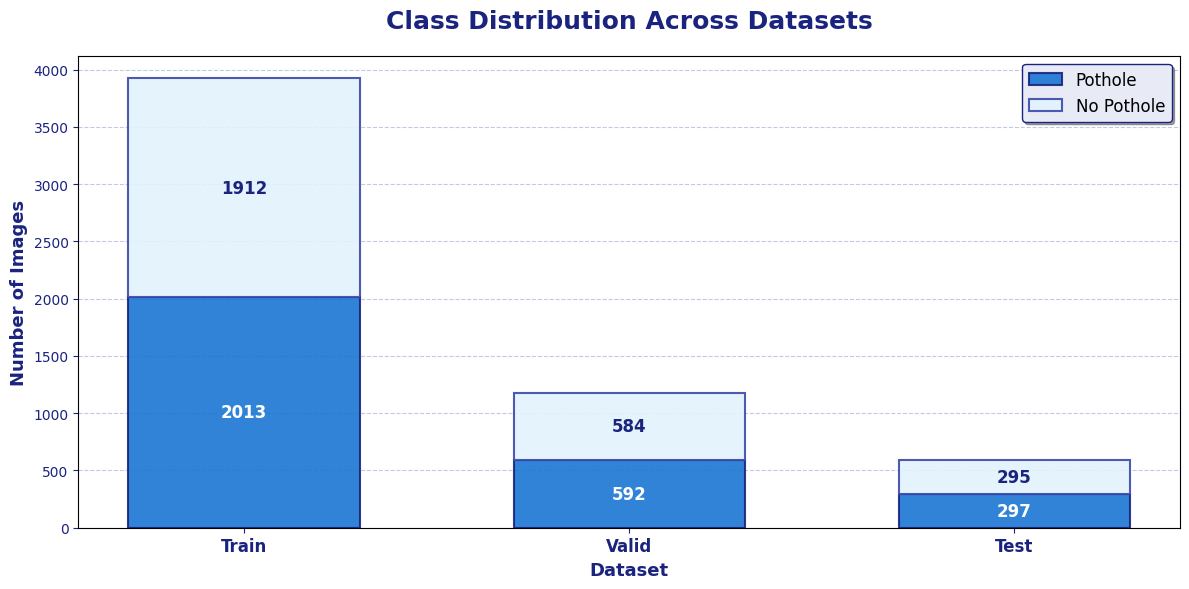

✅ Stacked bar chart saved!


In [10]:
# EDA Visualization: Stacked Bar Chart dengan tema Biru-Putih
fig, ax = plt.subplots(figsize=(12, 6), facecolor=COLOR_SCHEME['white'])
ax.set_facecolor(COLOR_SCHEME['white'])

x = np.arange(len(data_summary))
width = 0.6

# Warna: Biru untuk Pothole, Putih Kebiruan untuk No Pothole
p1 = ax.bar(x, data_summary['Pothole'], width, 
            label='Pothole', 
            color=COLOR_SCHEME['pothole'], 
            alpha=0.9,
            edgecolor=COLOR_SCHEME['primary'],
            linewidth=1.5)

p2 = ax.bar(x, data_summary['No Pothole'], width, 
            bottom=data_summary['Pothole'],
            label='No Pothole', 
            color=COLOR_SCHEME['nopothole'], 
            alpha=0.9,
            edgecolor=COLOR_SCHEME['accent'],
            linewidth=1.5)

# Labels dan Title
ax.set_ylabel('Number of Images', fontsize=13, weight='bold', color=COLOR_SCHEME['primary'])
ax.set_xlabel('Dataset', fontsize=13, weight='bold', color=COLOR_SCHEME['primary'])
ax.set_title('Class Distribution Across Datasets', fontsize=18, weight='bold', 
             color=COLOR_SCHEME['primary'], pad=20)

ax.set_xticks(x)
ax.set_xticklabels(data_summary['Dataset'], fontsize=12, weight='bold')
ax.tick_params(colors=COLOR_SCHEME['primary'])

# Legend
ax.legend(fontsize=12, loc='upper right', frameon=True,
          facecolor=COLOR_SCHEME['light'], edgecolor=COLOR_SCHEME['primary'], shadow=True)

# Grid
ax.grid(axis='y', alpha=0.3, color=COLOR_SCHEME['accent'], linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Add value labels
for i, (p, np_val) in enumerate(zip(data_summary['Pothole'], data_summary['No Pothole'])):
    ax.text(i, p/2, str(p), ha='center', va='center', fontsize=12, weight='bold', color='white')
    ax.text(i, p + np_val/2, str(np_val), ha='center', va='center', fontsize=12, weight='bold', 
            color=COLOR_SCHEME['primary'])

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'EDA', 'stacked_bar.png'), 
            dpi=150, bbox_inches='tight', facecolor=COLOR_SCHEME['white'])
plt.show()

print("✅ Stacked bar chart saved!")

## 🔧 TAHAP 4: DATA LOADING (TANPA AUGMENTASI)

In [11]:
def load_dataset_from_flat_folder(folder_path, img_size=(224, 224)):
    """
    Load dataset from flat folder structure where images are named:
    - POTHOLE_*.jpg/png for pothole images
    - NOPOTHOLE_*.jpg/png for no pothole images
    
    NO DATA AUGMENTATION - as requested by user
    """
    # Get all image files
    pothole_files = glob.glob(os.path.join(folder_path, 'POTHOLE_*'))
    nopothole_files = glob.glob(os.path.join(folder_path, 'NOPOTHOLE_*'))
    
    images = []
    labels = []
    
    print(f"  Loading {len(pothole_files)} pothole images...")
    # Load pothole images
    for img_path in pothole_files:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(1)  # Pothole = 1
    
    print(f"  Loading {len(nopothole_files)} no pothole images...")
    # Load no pothole images
    for img_path in nopothole_files:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(0)  # No Pothole = 0
    
    return np.array(images), np.array(labels)

# Load all datasets
print("📥 Loading Training Data...")
X_train, y_train = load_dataset_from_flat_folder(
    os.path.join(CONFIG['DATASET_PATH'], 'train'),
    CONFIG['IMG_SIZE']
)

print("\n📥 Loading Validation Data...")
X_valid, y_valid = load_dataset_from_flat_folder(
    os.path.join(CONFIG['DATASET_PATH'], 'valid'),
    CONFIG['IMG_SIZE']
)

print("\n📥 Loading Test Data...")
X_test, y_test = load_dataset_from_flat_folder(
    os.path.join(CONFIG['DATASET_PATH'], 'test'),
    CONFIG['IMG_SIZE']
)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_valid_cat = to_categorical(y_valid, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print("\n" + "="*70)
print("✅ DATA LOADED SUCCESSFULLY!")
print("="*70)
print(f"Train: {X_train.shape[0]} images")
print(f"  - Pothole: {np.sum(y_train == 1)}")
print(f"  - No Pothole: {np.sum(y_train == 0)}")
print(f"\nValid: {X_valid.shape[0]} images")
print(f"  - Pothole: {np.sum(y_valid == 1)}")
print(f"  - No Pothole: {np.sum(y_valid == 0)}")
print(f"\nTest: {X_test.shape[0]} images")
print(f"  - Pothole: {np.sum(y_test == 1)}")
print(f"  - No Pothole: {np.sum(y_test == 0)}")
print("="*70)
print("⚠️  NO DATA AUGMENTATION (as requested)")
print("="*70)

📥 Loading Training Data...
  Loading 2013 pothole images...
  Loading 1912 no pothole images...

📥 Loading Validation Data...
  Loading 592 pothole images...
  Loading 584 no pothole images...

📥 Loading Test Data...
  Loading 297 pothole images...
  Loading 295 no pothole images...

✅ DATA LOADED SUCCESSFULLY!
Train: 3925 images
  - Pothole: 2013
  - No Pothole: 1912

Valid: 1176 images
  - Pothole: 592
  - No Pothole: 584

Test: 592 images
  - Pothole: 297
  - No Pothole: 295
⚠️  NO DATA AUGMENTATION (as requested)


## 🏗️ TAHAP 5: BUILD CNN MODEL

In [12]:
def create_cnn_model(input_shape=(224, 224, 3), num_classes=2):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
model = create_cnn_model(input_shape=(*CONFIG['IMG_SIZE'], 3), num_classes=CONFIG['NUM_CLASSES'])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("✅ Model created and compiled!")
model.summary()

✅ Model created and compiled!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,013,858 (99.23 MB)

 Trainable params: 26,012,194 (99.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

## 🎯 TAHAP 6: TRAINING MODEL

In [13]:
# Callbacks
model_callbacks = [
    ModelCheckpoint(
        os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',  # Monitor accuracy
        patience=3,  # Stop jika 3 epoch tidak naik
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured!")

✅ Callbacks configured!


In [14]:
# Train the model
print("🚀 Starting training...")

history = model.fit(
    X_train, y_train_cat,
    batch_size=CONFIG['BATCH_SIZE'],
    epochs=CONFIG['EPOCHS'],
    validation_data=(X_valid, y_valid_cat),
    callbacks=model_callbacks,
    verbose=1
)

print("\n✅ Training completed!")

🚀 Starting training...
Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8348 - loss: 0.4484 - precision: 0.8348 - recall: 0.8348
Epoch 1: val_accuracy improved from -inf to 0.50595, saving model to C:\UAP_MachineLearning\PureCNN\Model\best_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.8352 - loss: 0.4474 - precision: 0.8352 - recall: 0.8352 - val_accuracy: 0.5060 - val_loss: 1.4584 - val_precision: 0.5060 - val_recall: 0.5060 - learning_rate: 0.0010
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9533 - loss: 0.1247 - precision: 0.9533 - recall: 0.9533
Epoch 2: val_accuracy improved from 0.50595 to 0.51105, saving model to C:\UAP_MachineLearning\PureCNN\Model\best_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 464s 4s/step - accuracy: 0.9533 - loss: 0.1247 - precision: 0.9533 - recall: 0.9533 - val_accuracy: 0.5111 - val_loss: 1.4271 - val_precision: 0.5111 - val_recall: 0.5111 - learning_rate: 0.0010
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━

In [15]:
# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(CONFIG['OUTPUT_PATH'], 'Training', 'training_history.csv'), index=False)

with open(os.path.join(CONFIG['OUTPUT_PATH'], 'Training', 'training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

print("✅ Training history saved!")

✅ Training history saved!


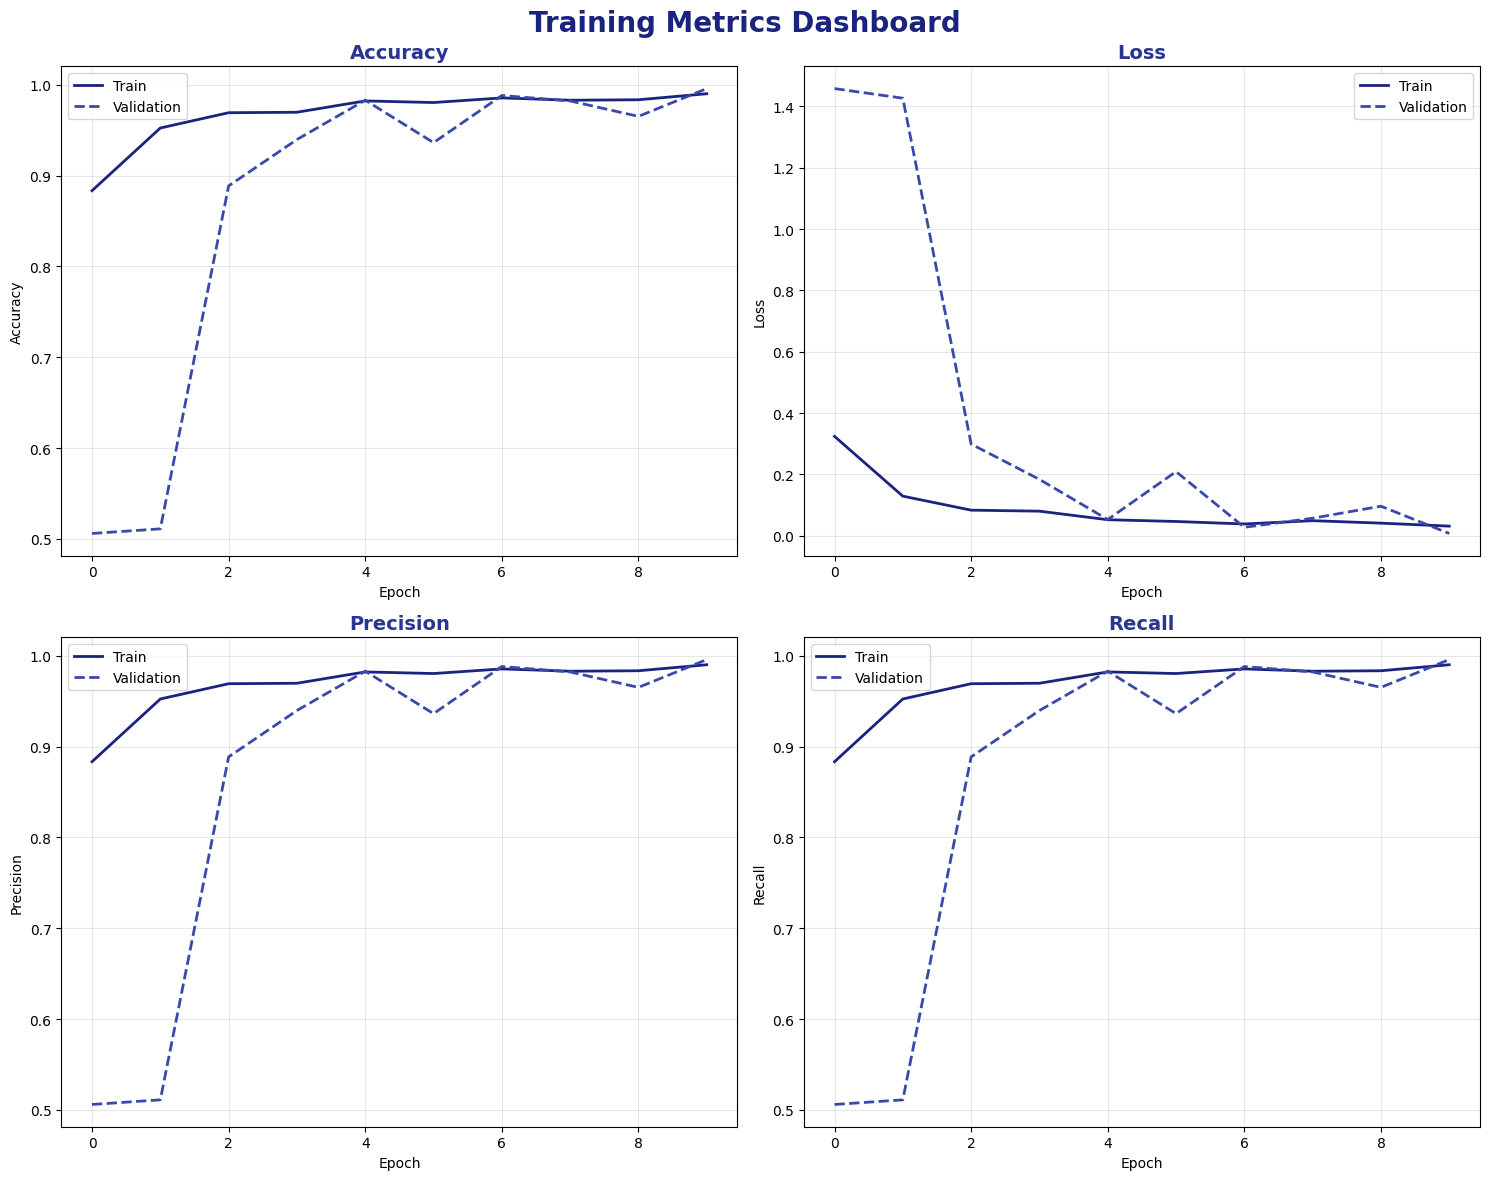

✅ Training visualization saved!


In [16]:
# Training Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training Metrics Dashboard', fontsize=20, color=COLOR_SCHEME['primary'], weight='bold')

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train', color=COLOR_SCHEME['primary'], linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', 
                color=COLOR_SCHEME['accent'], linewidth=2, linestyle='--')
axes[0, 0].set_title('Accuracy', fontsize=14, color=COLOR_SCHEME['secondary'], weight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train', color=COLOR_SCHEME['primary'], linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', 
                color=COLOR_SCHEME['accent'], linewidth=2, linestyle='--')
axes[0, 1].set_title('Loss', fontsize=14, color=COLOR_SCHEME['secondary'], weight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train', color=COLOR_SCHEME['primary'], linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation', 
                color=COLOR_SCHEME['accent'], linewidth=2, linestyle='--')
axes[1, 0].set_title('Precision', fontsize=14, color=COLOR_SCHEME['secondary'], weight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train', color=COLOR_SCHEME['primary'], linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation', 
                color=COLOR_SCHEME['accent'], linewidth=2, linestyle='--')
axes[1, 1].set_title('Recall', fontsize=14, color=COLOR_SCHEME['secondary'], weight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'Training', 'training_metrics.png'), 
            dpi=150, bbox_inches='tight', facecolor=COLOR_SCHEME['light'])
plt.show()

print("✅ Training visualization saved!")

## 📈 TAHAP 7: EVALUATION

In [17]:
# Evaluate on all datasets
print("\n" + "="*70)
print("EVALUATING MODEL")
print("="*70)

# Train
train_pred = np.argmax(model.predict(X_train), axis=1)
print("\nTRAIN SET:")
print(classification_report(y_train, train_pred, target_names=CONFIG['CLASSES']))

# Valid
valid_pred = np.argmax(model.predict(X_valid), axis=1)
print("\nVALIDATION SET:")
print(classification_report(y_valid, valid_pred, target_names=CONFIG['CLASSES']))

# Test
test_pred = np.argmax(model.predict(X_test), axis=1)
print("\nTEST SET:")
print(classification_report(y_test, test_pred, target_names=CONFIG['CLASSES']))

print("="*70)


EVALUATING MODEL
123/123 ━━━━━━━━━━━━━━━━━━━━ 67s 531ms/step

TRAIN SET:
              precision    recall  f1-score   support

   NOPOTHOLE       1.00      1.00      1.00      1912
     POTHOLE       1.00      1.00      1.00      2013

    accuracy                           1.00      3925
   macro avg       1.00      1.00      1.00      3925
weighted avg       1.00      1.00      1.00      3925

37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 484ms/step

VALIDATION SET:
              precision    recall  f1-score   support

   NOPOTHOLE       1.00      0.99      1.00       584
     POTHOLE       0.99      1.00      1.00       592

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step

TEST SET:
              precision    recall  f1-score   support

   NOPOTHOLE       1.00      0.99      0.99       295
     POTHOLE       0.99      1.00      0.99       2

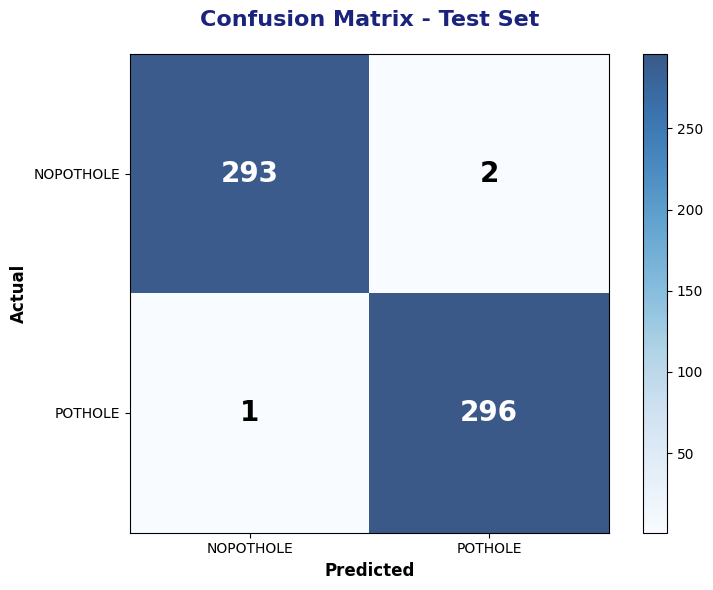

✅ Confusion matrix saved!


In [18]:
# Confusion Matrix for Test Set
cm = confusion_matrix(y_test, test_pred)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues', alpha=0.8)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(CONFIG['CLASSES'])))
ax.set_yticks(np.arange(len(CONFIG['CLASSES'])))
ax.set_xticklabels(CONFIG['CLASSES'])
ax.set_yticklabels(CONFIG['CLASSES'])

for i in range(len(CONFIG['CLASSES'])):
    for j in range(len(CONFIG['CLASSES'])):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", 
                      color="white" if cm[i, j] > cm.max() / 2 else "black",
                      fontsize=20, weight='bold')

ax.set_title('Confusion Matrix - Test Set', fontsize=16, 
            color=COLOR_SCHEME['primary'], weight='bold', pad=20)
ax.set_ylabel('Actual', fontsize=12, weight='bold')
ax.set_xlabel('Predicted', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'Evaluation', 'confusion_matrix.png'),
           dpi=150, bbox_inches='tight', facecolor=COLOR_SCHEME['light'])
plt.show()

print("✅ Confusion matrix saved!")

## CELL 7B: PREDICTION & TESTING

In [20]:
# Prediction on Test Set
print("\n" + "="*70)
print("🔮 PREDICTION ON TEST SET")
print("="*70)

# Get predictions
test_predictions = model.predict(X_test, verbose=1)
test_pred = np.argmax(test_predictions, axis=1)

# Detailed results
print("\n📊 Test Set Results:")
print(f"Total Test Images: {len(y_test)}")
print(f"Correct Predictions: {np.sum(test_pred == y_test)}")
print(f"Wrong Predictions: {np.sum(test_pred != y_test)}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred)*100:.2f}%")

# Classification Report
print("\n📈 Detailed Classification Report:")
print(classification_report(y_test, test_pred, target_names=CONFIG['CLASSES']))

# Save predictions
predictions_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': test_pred,
    'True_Class': [CONFIG['CLASSES'][i] for i in y_test],
    'Predicted_Class': [CONFIG['CLASSES'][i] for i in test_pred],
    'Correct': y_test == test_pred
})
predictions_df.to_csv(os.path.join(CONFIG['OUTPUT_PATH'], 'Evaluation', 'test_predictions.csv'), index=False)

print("\n✅ Test predictions saved!")


🔮 PREDICTION ON TEST SET
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step

📊 Test Set Results:
Total Test Images: 592
Correct Predictions: 589
Wrong Predictions: 3
Test Accuracy: 99.49%

📈 Detailed Classification Report:
              precision    recall  f1-score   support

   NOPOTHOLE       1.00      0.99      0.99       295
     POTHOLE       0.99      1.00      0.99       297

    accuracy                           0.99       592
   macro avg       0.99      0.99      0.99       592
weighted avg       0.99      0.99      0.99       592


✅ Test predictions saved!


## CELL 8: ERROR ANALYSIS


🔍 ERROR ANALYSIS

Total Misclassified: 3 / 592
Error Rate: 0.51%

📊 Error Distribution:
  True Class Predicted Class  Count
0  NOPOTHOLE         POTHOLE      2
1    POTHOLE       NOPOTHOLE      1


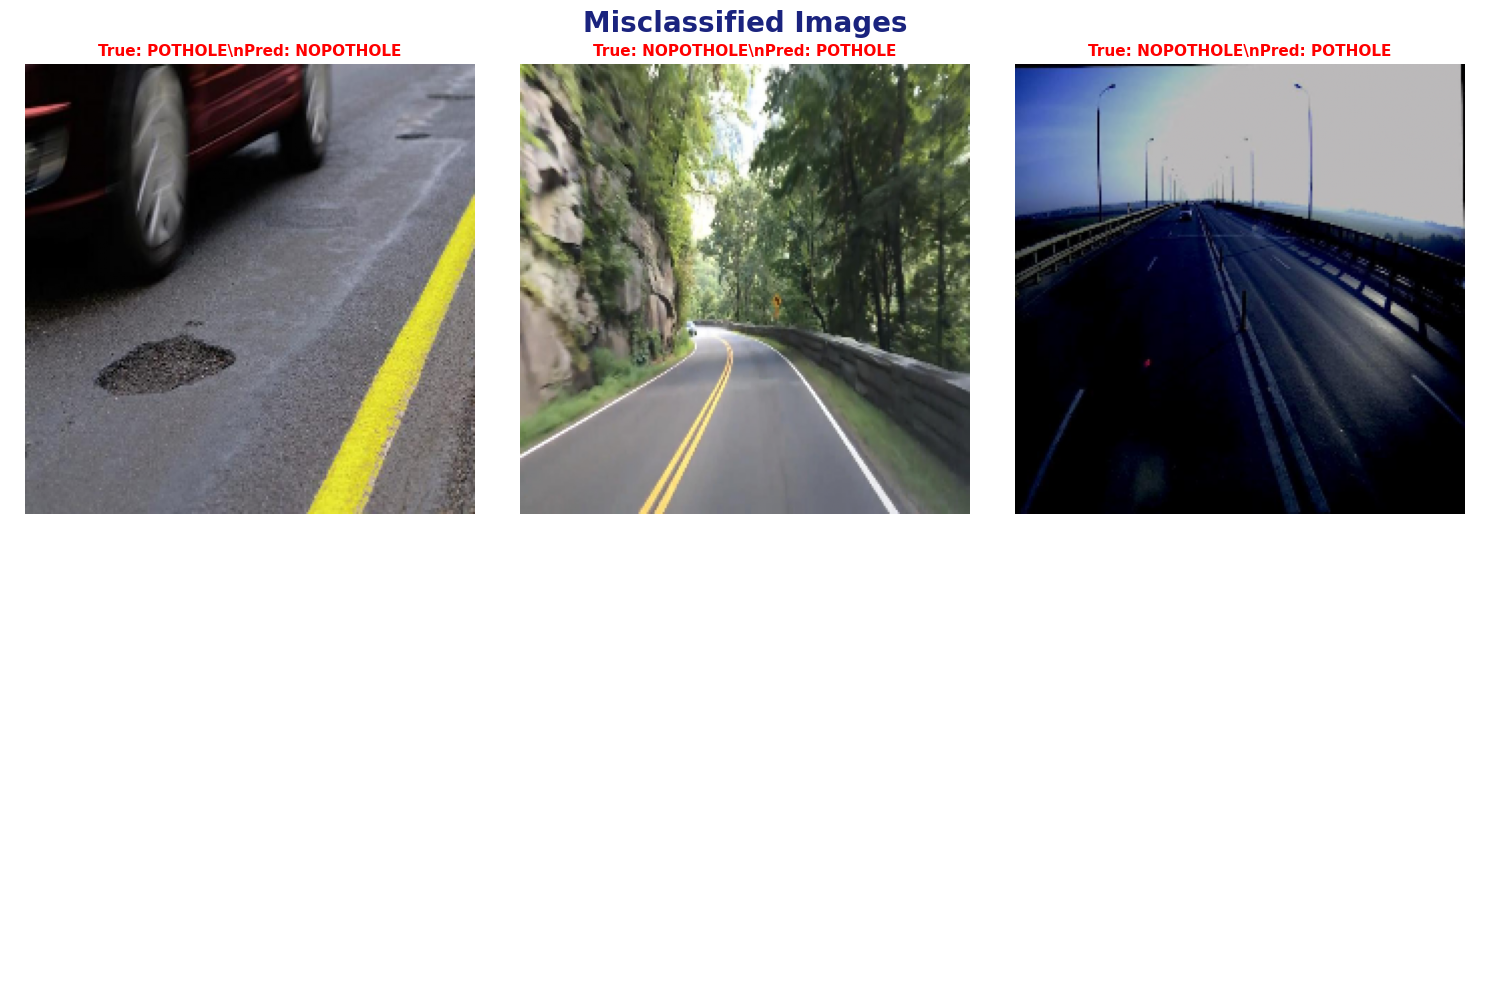


✅ Error analysis completed!


In [24]:
# Error Analysis
print("\n" + "="*70)
print("🔍 ERROR ANALYSIS")
print("="*70)

# Find misclassified images
misclassified_idx = np.where(test_pred != y_test)[0]

print(f"\nTotal Misclassified: {len(misclassified_idx)} / {len(y_test)}")
print(f"Error Rate: {(len(misclassified_idx)/len(y_test))*100:.2f}%")

# Error distribution
error_dist = pd.DataFrame({
    'True Class': [CONFIG['CLASSES'][y_test[i]] for i in misclassified_idx],
    'Predicted Class': [CONFIG['CLASSES'][test_pred[i]] for i in misclassified_idx]
})

error_summary = error_dist.groupby(['True Class', 'Predicted Class']).size().reset_index(name='Count')
print("\n📊 Error Distribution:")
print(error_summary)

# Save error analysis
error_summary.to_csv(os.path.join(CONFIG['OUTPUT_PATH'], 'Evaluation', 'error_analysis.csv'), index=False)

# Visualize some misclassified images
if len(misclassified_idx) > 0:
    num_show = min(6, len(misclassified_idx))
    sample_errors = np.random.choice(misclassified_idx, num_show, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), facecolor=COLOR_SCHEME['white'])
    fig.suptitle('Misclassified Images', fontsize=20, color=COLOR_SCHEME['primary'], weight='bold')
    
    for idx, err_idx in enumerate(sample_errors):
        row, col = idx // 3, idx % 3
        axes[row, col].imshow(X_test[err_idx])
        
        true_label = CONFIG['CLASSES'][y_test[err_idx]]
        pred_label = CONFIG['CLASSES'][test_pred[err_idx]]
        
        axes[row, col].set_title(f'True: {true_label}\\nPred: {pred_label}', 
                                 color='red', fontsize=11, weight='bold')
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for idx in range(num_show, 6):
        row, col = idx // 3, idx % 3
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'Evaluation', 'misclassified_images.png'),
               dpi=150, bbox_inches='tight', facecolor=COLOR_SCHEME['white'])
    plt.show()

print("\n✅ Error analysis completed!")

## CELL 9: XAI - GRAD-CAM


🎨 EXPLAINABLE AI - GRAD-CAM
✅ Last Conv Layer: conv2d_5

🔍 Generating Grad-CAM visualizations...
  ✓ Sample 1/6 completed
  ✓ Sample 2/6 completed
  ✓ Sample 3/6 completed
  ✓ Sample 4/6 completed


  ✓ Sample 5/6 completed


  ✓ Sample 6/6 completed


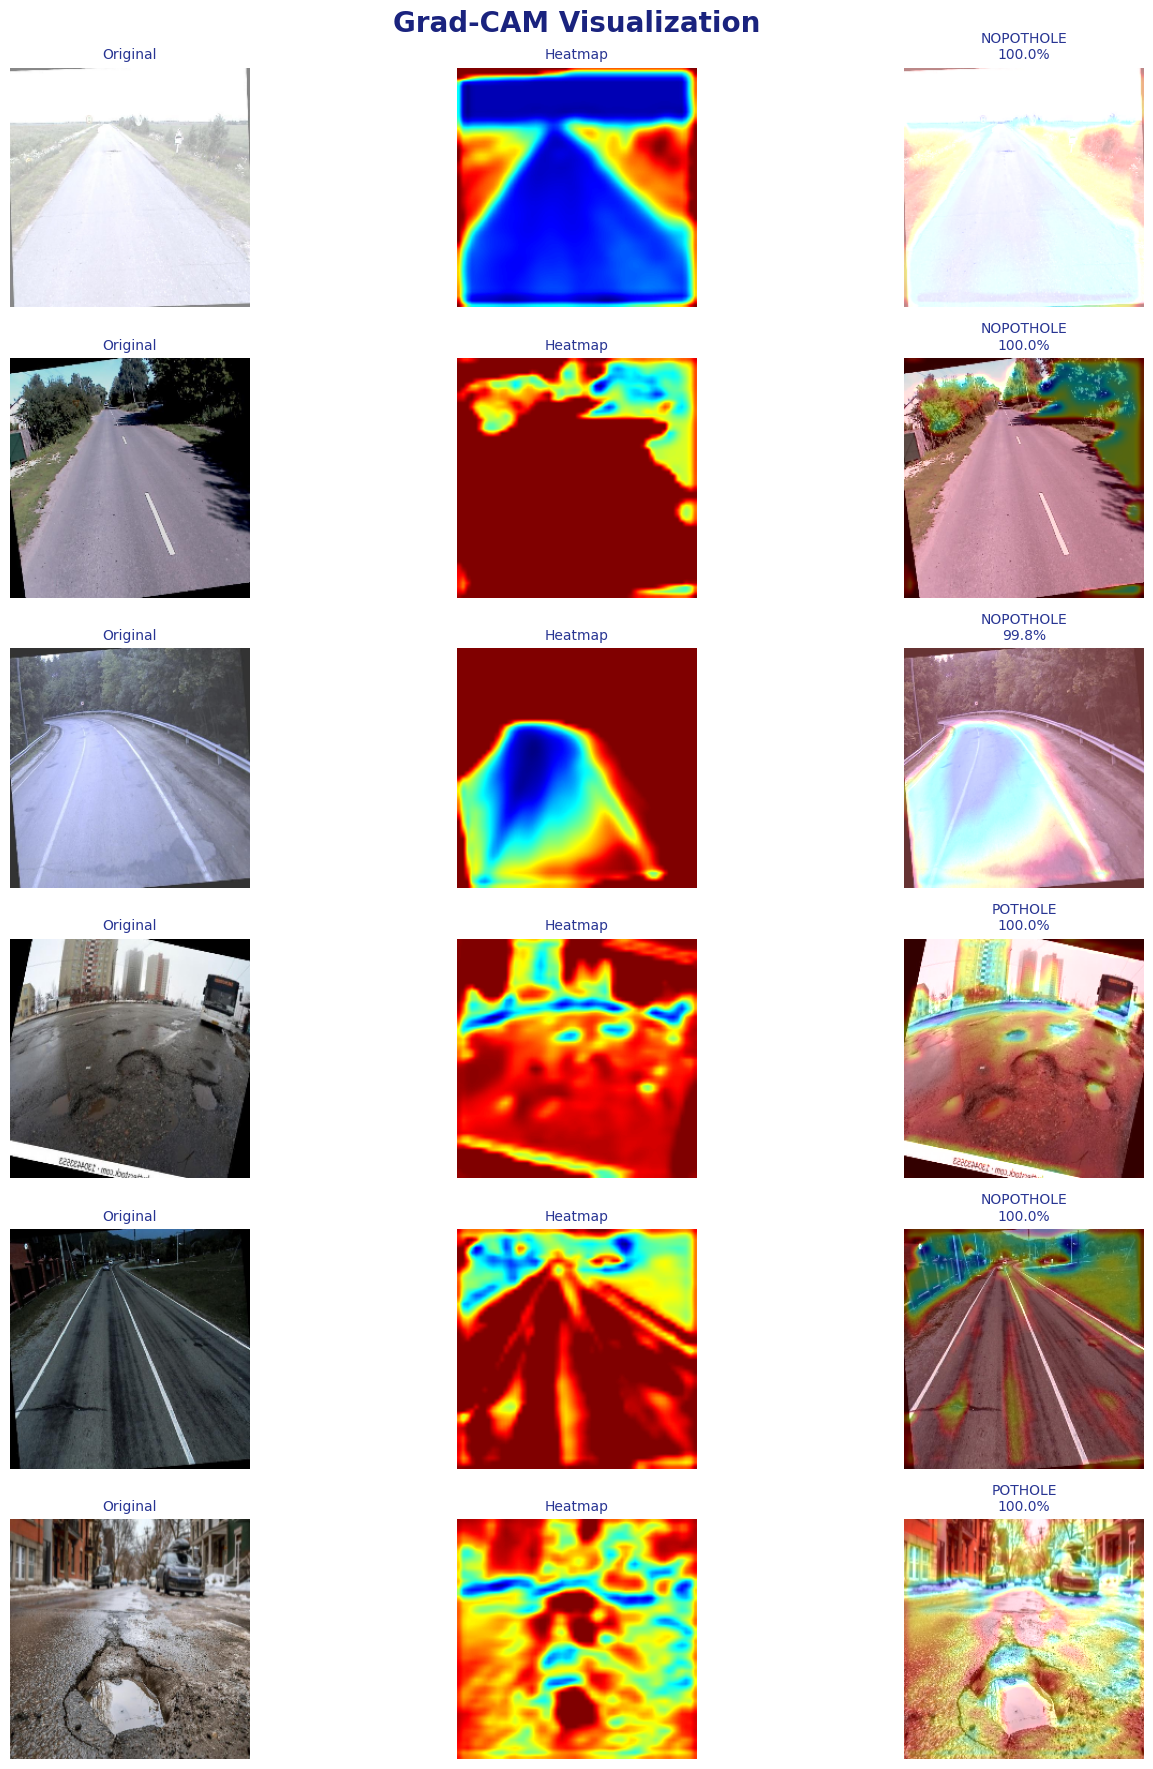


✅ Grad-CAM visualization completed!


In [26]:
# Grad-CAM Implementation - FINAL FIX untuk Keras 3.x
print("\n" + "="*70)
print("🎨 EXPLAINABLE AI - GRAD-CAM")
print("="*70)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap - Keras 3.x Compatible"""
    
    # Get the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # Create a function that returns the output of last conv layer and predictions
    @tf.function
    def get_gradients(images):
        with tf.GradientTape() as tape:
            # Forward pass
            last_conv_output = None
            x = images
            
            # Pass through layers until we get to last conv layer
            for layer in model.layers:
                x = layer(x)
                if layer.name == last_conv_layer_name:
                    last_conv_output = x
                    tape.watch(last_conv_output)
            
            predictions = x  # Final output
            
            # Get the class channel
            if pred_index is None:
                pred_idx = tf.argmax(predictions[0])
            else:
                pred_idx = pred_index
            class_channel = predictions[:, pred_idx]
        
        # Get gradients
        grads = tape.gradient(class_channel, last_conv_output)
        return last_conv_output, grads, predictions
    
    # Get outputs and gradients
    conv_outputs, grads, preds = get_gradients(img_array)
    
    # Pool the gradients across the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the channels by the gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    
    return heatmap.numpy()

# Find last conv layer
last_conv_layer = None
for layer in reversed(model.layers):
    if 'conv' in layer.name.lower():
        last_conv_layer = layer.name
        break

if last_conv_layer is None:
    print("❌ No convolutional layer found! Skipping Grad-CAM...")
else:
    print(f"✅ Last Conv Layer: {last_conv_layer}")
    
    # Generate Grad-CAM for sample images
    num_samples = 6
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*3), facecolor=COLOR_SCHEME['white'])
    fig.suptitle('Grad-CAM Visualization', fontsize=20, color=COLOR_SCHEME['primary'], weight='bold')
    
    print("\n🔍 Generating Grad-CAM visualizations...")
    for idx, img_idx in enumerate(sample_indices):
        img_array = np.expand_dims(X_test[img_idx], axis=0)
        
        # Get prediction
        preds = model.predict(img_array, verbose=0)
        pred_class = np.argmax(preds[0])
        confidence = preds[0][pred_class]
        
        # Generate heatmap
        try:
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer, pred_class)
            
            # Superimpose heatmap
            img = (X_test[img_idx] * 255).astype('uint8')
            heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            heatmap_colored = np.uint8(255 * heatmap_resized)
            heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
            superimposed_img = heatmap_colored * 0.4 + img
            superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
            
            # Plot
            axes[idx, 0].imshow(img)
            axes[idx, 0].set_title('Original', color=COLOR_SCHEME['secondary'], fontsize=10)
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(heatmap_colored)
            axes[idx, 1].set_title('Heatmap', color=COLOR_SCHEME['secondary'], fontsize=10)
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(superimposed_img)
            axes[idx, 2].set_title(f'{CONFIG["CLASSES"][pred_class]}\n{confidence:.1%}', 
                                  color=COLOR_SCHEME['secondary'], fontsize=10)
            axes[idx, 2].axis('off')
            
            print(f"  ✓ Sample {idx+1}/{num_samples} completed")
            
        except Exception as e:
            print(f"  ✗ Sample {idx+1} failed: {e}")
            # Show original image only
            axes[idx, 0].imshow(img)
            axes[idx, 0].set_title('Original', color=COLOR_SCHEME['secondary'], fontsize=10)
            axes[idx, 0].axis('off')
            axes[idx, 1].axis('off')
            axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'XAI', 'gradcam_samples.png'),
               dpi=150, bbox_inches='tight', facecolor=COLOR_SCHEME['white'])
    plt.show()
    
    print("\n✅ Grad-CAM visualization completed!")

## CELL 10: SAVE FINAL MODEL (FIXED)

In [28]:
# Save final model - FIXED VERSION (Unicode Error Resolved)
print("\n" + "="*70)
print("💾 SAVING FINAL MODEL")
print("="*70)

# Save model (format .keras - no warning)
model.save(os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'final_model.keras'))
print("✅ Model saved: final_model.keras")

# Save weights (harus pakai .weights.h5)
model.save_weights(os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'model.weights.h5'))
print("✅ Weights saved: model.weights.h5")

# Save model architecture - FIXED: tambah encoding='utf-8'
with open(os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'model_architecture.txt'), 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("✅ Architecture saved: model_architecture.txt")

# Save model summary
summary = {
    'project_info': {
        'name': 'Pothole Detection System',
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': 'CNN',
        'classes': CONFIG['CLASSES']
    },
    'dataset': {
        'total_images': int(data_summary['Total'].sum()),
        'train': int(X_train.shape[0]),
        'valid': int(X_valid.shape[0]),
        'test': int(X_test.shape[0])
    },
    'performance': {
        'test_accuracy': float(accuracy_score(y_test, test_pred)),
        'test_precision': float(precision_score(y_test, test_pred)),
        'test_recall': float(recall_score(y_test, test_pred)),
        'test_f1': float(f1_score(y_test, test_pred))
    }
}

with open(os.path.join(CONFIG['OUTPUT_PATH'], 'project_summary.json'), 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=4)

print("\n" + "="*70)
print("🎉 ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*70)
print(json.dumps(summary, indent=2))
print("="*70)
print(f"\n📁 All outputs saved to: {CONFIG['OUTPUT_PATH']}")


💾 SAVING FINAL MODEL
✅ Model saved: final_model.keras
✅ Weights saved: model.weights.h5


✅ Architecture saved: model_architecture.txt

🎉 ALL TASKS COMPLETED SUCCESSFULLY!
{
  "project_info": {
    "name": "Pothole Detection System",
    "date": "2025-12-23 21:23:22",
    "model_type": "CNN",
    "classes": [
      "NOPOTHOLE",
      "POTHOLE"
    ]
  },
  "dataset": {
    "total_images": 5693,
    "train": 3925,
    "valid": 1176,
    "test": 592
  },
  "performance": {
    "test_accuracy": 0.9949324324324325,
    "test_precision": 0.9932885906040269,
    "test_recall": 0.9966329966329966,
    "test_f1": 0.9949579831932773
  }
}

📁 All outputs saved to: C:\UAP_MachineLearning\PureCNN


## FILE CHECKER - Cek Semua Output

In [30]:
# FILE CHECKER - Verifikasi semua output tersimpan
print("\n" + "="*70)
print("📋 CHECKING ALL OUTPUT FILES")
print("="*70)

# Expected files per folder
expected_files = {
    'EDA': [
        'stacked_bar.png',
        'distribution_pie.png',  # Optional jika pakai plotly
        'sunburst_distribution.html'  # Optional jika pakai plotly
    ],
    'Preprocessing': [
        # Folder ini mungkin kosong karena tidak pakai augmentasi
    ],
    'Model': [
        'best_model.keras',
        'final_model.keras',
        'model.weights.h5',
        'model_architecture.txt'
    ],
    'Training': [
        'training_history.csv',
        'training_history.pkl',
        'training_metrics.png'
    ],
    'Evaluation': [
        'test_predictions.csv',
        'confusion_matrix.png',
        'error_analysis.csv',
        'misclassified_images.png'
    ],
    'XAI': [
        'saliency_maps.png',  # atau 'gradcam_samples.png'
    ]
}

# Check each folder
all_good = True
missing_files = []

for folder, files in expected_files.items():
    folder_path = os.path.join(CONFIG['OUTPUT_PATH'], folder)
    print(f"\n📁 {folder}/")
    
    if not os.path.exists(folder_path):
        print(f"  ❌ Folder tidak ada!")
        all_good = False
        continue
    
    # List actual files
    actual_files = os.listdir(folder_path)
    
    if len(actual_files) == 0 and len(files) > 0:
        print(f"  ⚠️  Folder kosong!")
        for file in files:
            missing_files.append(f"{folder}/{file}")
        all_good = False
    else:
        # Check each expected file
        for file in files:
            file_path = os.path.join(folder_path, file)
            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path)
                print(f"  ✅ {file} ({file_size:,} bytes)")
            else:
                print(f"  ❌ {file} - MISSING!")
                missing_files.append(f"{folder}/{file}")
                all_good = False
        
        # Show extra files
        expected_names = set(files)
        actual_names = set(actual_files)
        extra_files = actual_names - expected_names
        
        for extra in extra_files:
            extra_path = os.path.join(folder_path, extra)
            if os.path.isfile(extra_path):
                file_size = os.path.getsize(extra_path)
                print(f"  ℹ️  {extra} ({file_size:,} bytes) - Extra file")

# Check root files
print(f"\n📁 Root (PureCNN)/")
root_files = ['project_summary.json', 'code.ipynb']
for file in root_files:
    file_path = os.path.join(CONFIG['OUTPUT_PATH'], file)
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path)
        print(f"  ✅ {file} ({file_size:,} bytes)")
    else:
        print(f"  ❌ {file} - MISSING!")
        missing_files.append(file)
        all_good = False

# Summary
print("\n" + "="*70)
if all_good:
    print("✅ ALL FILES PRESENT AND ACCOUNTED FOR!")
else:
    print("⚠️  SOME FILES ARE MISSING:")
    for missing in missing_files:
        print(f"  - {missing}")
print("="*70)

# Generate file inventory
inventory = {
    'check_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_folders': len(expected_files),
    'status': 'complete' if all_good else 'incomplete',
    'missing_files': missing_files,
    'folders': {}
}

for folder in expected_files.keys():
    folder_path = os.path.join(CONFIG['OUTPUT_PATH'], folder)
    if os.path.exists(folder_path):
        files_in_folder = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        inventory['folders'][folder] = {
            'file_count': len(files_in_folder),
            'files': files_in_folder
        }

# Save inventory
with open(os.path.join(CONFIG['OUTPUT_PATH'], 'file_inventory.json'), 'w', encoding='utf-8') as f:
    json.dump(inventory, f, indent=4)

print(f"\n📄 File inventory saved: file_inventory.json")


📋 CHECKING ALL OUTPUT FILES

📁 EDA/
  ✅ stacked_bar.png (65,810 bytes)
  ❌ distribution_pie.png - MISSING!
  ✅ sunburst_distribution.html (4,850,552 bytes)
  ℹ️  sample_nopothole.png (2,561,854 bytes) - Extra file
  ℹ️  sample_pothole.png (3,337,662 bytes) - Extra file

📁 Preprocessing/

📁 Model/
  ✅ best_model.keras (312,276,694 bytes)
  ✅ final_model.keras (312,276,245 bytes)
  ✅ model.weights.h5 (312,256,480 bytes)
  ✅ model_architecture.txt (9,637 bytes)
  ℹ️  final_model.h5 (312,304,096 bytes) - Extra file
  ℹ️  best_model.h5 (312,304,096 bytes) - Extra file

📁 Training/
  ✅ training_history.csv (1,856 bytes)
  ✅ training_history.pkl (972 bytes)
  ✅ training_metrics.png (177,518 bytes)

📁 Evaluation/
  ✅ test_predictions.csv (16,636 bytes)
  ✅ confusion_matrix.png (39,176 bytes)
  ✅ error_analysis.csv (76 bytes)
  ✅ misclassified_images.png (377,177 bytes)

📁 XAI/
  ❌ saliency_maps.png - MISSING!
  ℹ️  gradcam_samples.png (2,578,093 bytes) - Extra file

📁 Root (PureCNN)/
  ✅ proj